In [28]:
import pandas as pd
import numpy as np
from nltk import RegexpTokenizer
from nltk.corpus import stopwords

import nltk
nltk.download('stopwords')

import gensim

from sklearn.cluster import KMeans
from sklearn import metrics
import pylab as pl

import matplotlib.pyplot as plt
from sklearn.decomposition import PCA

import warnings
warnings.filterwarnings('ignore')

import emoji
import regex as re
from nltk.tokenize import word_tokenize
from nltk.stem import PorterStemmer
from nltk.corpus import wordnet
from nltk.stem import WordNetLemmatizer

from sklearn.metrics import silhouette_samples, silhouette_score
from sklearn.metrics import pairwise_distances

[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/natalie/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


# Data 

In [2]:
data = pd.read_csv('scrape/restaurant-data/cleaned_restaurant_reviews.csv', index_col=0).reset_index(drop=True)
data.head(2)

,url,name,neighbourhood,price,categories,review,user,date,cleaned_price,cleaned_categories,...,Western,Recommended,Sustainable,Novel,Desserts,Bites,Supper,Breakfast & Brunch,Halal,region
0,https://www.burpple.com/bedok-85-market?bp_ref...,85 Fengshan Centre,Bedok,~$5/pax,"['Hawker Food', 'Supper', 'Cheap & Good']","\nFish Ball Minced Meat Noodle\nFishball, meat...",Triffany Lim,21m ago,5.0,"['Local Delights', 'Supper', 'Value']",...,0,0,0,0,0,0,1,0,0,East
1,https://www.burpple.com/bedok-85-market?bp_ref...,85 Fengshan Centre,Bedok,~$5/pax,"['Hawker Food', 'Supper', 'Cheap & Good']","\nOrh lua\nThere are a couple of stores, but g...",Ally Tan,Jul 30 at 4:12pm,5.0,"['Local Delights', 'Supper', 'Value']",...,0,0,0,0,0,0,1,0,0,East


### Review Text Cleaning
(to shift to eda code + run with translation)

In [3]:
ps = PorterStemmer()
lemmatizer = WordNetLemmatizer()

In [4]:
def decontracted(phrase):
    # specific
    phrase = re.sub(r"won\'t", "will not", phrase)
    phrase = re.sub(r"can\'t", "can not", phrase)
    phrase = re.sub(r"didn\'t", "did not", phrase)
    phrase = re.sub(r"don\'t", "do not", phrase)
    phrase = re.sub(r"o\'clock", "clock", phrase)
    phrase = re.sub(r"couldn\'t", "could not", phrase)
    phrase = re.sub(r"that\'s", "that is", phrase)       
    phrase = re.sub(r"go-around", "go around", phrase)  
    # general
    phrase = re.sub(r"\'ve", " have", phrase)
    phrase = re.sub(r"n\'t", " not", phrase)
    phrase = re.sub(r"\'re", " are", phrase)
    #phrase = re.sub(r"\'s", " is", phrase)
    phrase = re.sub(r"\'d", " would", phrase)
    phrase = re.sub(r"\'ll", " will", phrase)
    phrase = re.sub(r"\'t", " not", phrase)
    phrase = re.sub(r"\'m", " am", phrase)
    return phrase

In [5]:
def get_wordnet_pos(treebank_tag):
    if treebank_tag.startswith('J'):
        return wordnet.ADJ
    elif treebank_tag.startswith('V'):
        return wordnet.VERB
    elif treebank_tag.startswith('N'):
        return wordnet.NOUN
    elif treebank_tag.startswith('R'):
        return wordnet.ADV
    else:
        return None

In [6]:
stopwords = nltk.corpus.stopwords.words('english')
new_stopwords = ['address', 'note', 'tel', 'website', 'open', 'burpple']
add_stopwords = set(['br', 'the', 'i', 'me', 'my', 'myself', 'we', 'our', 'ours', 'ourselves', 'you', "you're", "you've",\
    "you'll", "you'd", 'your', 'yours', 'yourself', 'yourselves', 'he', 'him', 'his', 'himself', \
    'she', "she's", 'her', 'hers', 'herself', 'it', "it's", 'its', 'itself', 'they', 'them', 'their',\
    'theirs', 'themselves', 'what', 'which', 'who', 'whom', 'this', 'that', "that'll", 'these', 'those', \
    'am', 'is', 'are', 'was', 'were', 'be', 'been', 'being', 'have', 'has', 'had', 'having', 'do', 'does', \
    'did', 'doing', 'a', 'an', 'the', 'and', 'but', 'if', 'or', 'because', 'as', 'until', 'while', 'of', \
    'at', 'by', 'for', 'with', 'about', 'against', 'between', 'into', 'through', 'during', 'before', 'after',\
    'above', 'below', 'to', 'from', 'up', 'down', 'in', 'out', 'on', 'off', 'over', 'under', 'again', 'further',\
    'then', 'once', 'here', 'there', 'when', 'where', 'why', 'how', 'all', 'any', 'both', 'each', 'few', 'more',\
    'most', 'other', 'some', 'such', 'only', 'own', 'same', 'so', 'than', 'too', 'very', \
    's', 't', 'can', 'will', 'just', 'don', "don't", 'should', "should've", 'now', 'd', 'll', 'm', 'o', 're', \
    've', 'y', 'ain', 'aren', "aren't", 'couldn', "couldn't", 'didn', "didn't", 'doesn', "doesn't", 'hadn',\
    "hadn't", 'hasn', "hasn't", 'haven', "haven't", 'isn', "isn't", 'ma', 'mightn', "mightn't", 'mustn',\
    "mustn't", 'needn', "needn't", 'shan', "shan't", 'shouldn', "shouldn't", 'wasn', "wasn't", 'weren', "weren't", \
    'won', "won't", 'wouldn', "wouldn't"])
add_stopwords_2 =  ['n','s','m','i','1','2','3','4','5','6','7','8','9','10','one','two',
    'it','in','ve','well','could','would','really','also','even',
    'alway','always','still','never','much','thing','yet',
    'said','asked','did','go','got','do','make','know','think','come','going',
    'put','went','seem','order','ordered','give','eat','make','get']

stopwords.extend(new_stopwords)
stopwords.extend(add_stopwords)
stopwords.extend(add_stopwords_2)

In [7]:
cleaned_review_list = []
count = 0

for review in data['review']:
    # lower case
    review = review.lower()

    # deemojize
    review = emoji.demojize(review)

    # remove headers
    review = ' '.join(review.split('\n')[2:])

    # remove location (pushpin or location:)
    review = review.split('round_pushpin')[0]
    review = review.split('location:')[0]

    # clean punctuation
    review = re.sub(r'[^\w\s]', '', review)

    # tokenize
    tokens = word_tokenize(review)

    # remove stopwords and URLs
    tokens = [word for word in tokens if word not in stopwords]
    tokens = [word for word in tokens if 'http' not in word]
    tokens = [word for word in tokens if 'www' not in word]

    # decontraction
    tokens = [decontracted(word) for word in tokens]

    ### to add in translation code... shld translate each token

    ### lemmatization
    # POS tagging
    tokens = [nltk.pos_tag([word]) for word in tokens]
            
    # lemmatization
    tokens = [lemmatizer.lemmatize(word[0][0], get_wordnet_pos(word[0][1])) 
        if get_wordnet_pos(word[0][1])!=None else lemmatizer.lemmatize(word[0][0]) for word in tokens]
    
    ### WORD FREQUENCY
    # modify count if POS tag is adjective
    # new_tokens = []
    # for token in tokens:
    #     new_tokens.append(token)
    #     word, pos = nltk.pos_tag([token])[0]
    #     if pos == 'JJ' or pos == 'JJR' or pos == 'JJS' or pos == 'RB' or pos == 'RBR' or pos == 'RBS':  
    #         new_tokens.append(token) ### ADD 1 MORE WORD OCCURENCE
        #     if word in word_freq.keys():
        #         word_freq[word] += 2 ### TO CHANGE THIS PARAMETER (double frequency for adjectivies)
        #     else: 
        #         word_freq[word] = 2
        # else:
        #     if word in word_freq.keys():
        #         word_freq[word] += 1 
        #     else: 
        #         word_freq[word] = 1
        
    # concatenate tokens back
    cleaned_review = " ".join(tokens)
    cleaned_review_list.append(cleaned_review)

    if count%1000 == 0:
        print(count)
    count+=1

0
1000
2000
3000
4000
5000
6000
7000
8000
9000
10000
11000
12000
13000
14000
15000
16000
17000
18000
19000
20000
21000
22000
23000
24000
25000
26000
27000
28000


In [8]:
# replace the old cleaned text
data['cleaned_text'] = cleaned_review_list

In [9]:
# concatenate all the reviews for each restaurant
restaurant_review_df = data[['url', 'cleaned_text']]
restaurant_review_df = restaurant_review_df.groupby(['url'], as_index = False).agg({'cleaned_text': ' '.join})
restaurant_review_df.head(5)

,url,cleaned_text
0,https://www.burpple.com/108-matcha-saro?bp_ref...,s850 strong matcha flavor soft serve topped wh...
1,https://www.burpple.com/136-hong-kong-street-f...,zhi char feast family love tze char lose count...
2,https://www.burpple.com/15-stamford?bp_ref=%2F...,four hand dinner chef alvin chef jay legendary...
3,https://www.burpple.com/25-degrees-singapore?b...,oh yesh loveeeee burger goooooood locate hotel...
4,https://www.burpple.com/46-mittsu?bp_ref=%2Ff%...,signature firebird koreaninspired sandwich fry...


In [10]:
restaurant_review_df = restaurant_review_df.join(data.drop(['url', 'cleaned_text'], axis=1), how="left")

# Model

In [12]:
tokenizer = RegexpTokenizer(r'\w+')

def nlp_clean(data):
    new_data = []
    for d in data:
        new_str = d.lower()
        dlist = tokenizer.tokenize(new_str)
        new_data.append(dlist)
    return new_data

class LabeledLineSentence(object):
    def __init__(self, doc_list, labels_list):
        self.labels_list = labels_list
        self.doc_list = doc_list
    def __iter__(self):
        for idx, doc in enumerate(self.doc_list):
              yield gensim.models.doc2vec.TaggedDocument(doc, [self.labels_list[idx]])

In [13]:
# tokenize reviews
tokenized_reviews = nlp_clean(restaurant_review_df['cleaned_text'])

In [14]:
# doc2vec
# word embeddings: calculate use frequency -> calculate cosine similarity -> group based on similar usage of words. (LDA just the first step)
# vector size 1000 == randomly selecting 1000

def doc2vec(tokenized_reviews): #, word_freq
    it = LabeledLineSentence(tokenized_reviews, restaurant_review_df['url']) # label reviews with the restaurant url
    model = gensim.models.Doc2Vec(vector_size=1000, min_count=5, alpha=0.025, min_alpha=0.025) #### TO TUNE
    # model.build_vocab_from_freq(word_freq) #### TRY BUILD VOCAB FROM FREQ
    model.build_vocab(it)
    model.train(it, total_examples= model.corpus_count, epochs = 10, start_alpha=0.002, end_alpha=-0.016)

    print(model.corpus_count) ## check the corpus
    print(len(model.docvecs)) # check doc2vec.

    ### plot the accuracy of each epoch so we can see if its over or under-fitted
    ### tweak learning rate and number of epochs
    return it, model

## Similarity/K-Means Functions

In [15]:
def cosine_similarity_matrix(model):
    similarity_df = pd.DataFrame()

    for restaurant in it.labels_list:
        similarity_list = []
        for restaurant2 in it.labels_list:
            similarity_list.append(model.docvecs.similarity(restaurant, restaurant2))
        
        similarity_df[restaurant] = similarity_list

    similarity_df.index = list(it.labels_list)

    return similarity_df

In [30]:
def num_topics_silhouette_score(model):
    # get optimal number of topics
    Sum_of_squared_distances = []
    K = range(1,15)
    for k in K:
        kmeans = KMeans(n_clusters=k, init='k-means++', max_iter=100)
        X = kmeans.fit(model.dv.vectors) ###using documnet vecter numbers. doctag_syn0 calls doc2vec that is trained earlier.
        Sum_of_squared_distances.append(kmeans.inertia_)

    plt.plot(K, Sum_of_squared_distances, 'bx-')
    plt.xlabel('k')
    plt.ylabel('Sum_of_squared_distances')
    plt.title('Elbow Method For Optimal k')
    plt.show()

    ### K-means Accuracy (Silhouette Score)
    accuracy = []
    for k in K:
        if k == 1:
            pass
        else: 
            kmeans = KMeans(n_clusters=k, init='k-means++', max_iter=100)
            X = kmeans.fit(model.dv.vectors) ###using documnet vecter numbers. doctag_syn0 calls doc2vec that is trained earlier.
            Sum_of_squared_distances.append(kmeans.inertia_)
            silhouette_score_average = silhouette_score(model.dv.vectors, kmeans.predict(model.dv.vectors))
            accuracy.append(silhouette_score_average)
    x = list(range(2,len(K)+1))
    plt.plot(x,accuracy)
    plt.title('Silhouette Score For Each K')
    plt.show()

In [18]:
def pca_plot(model):
    l = kmeans.fit_predict(model.dv.vectors)
    pca = PCA(n_components=2).fit(model.dv.vectors)
    datapoint = pca.transform(model.dv.vectors)

    plt.figure
    label1 = ["#FF6961", "#FFB480", "#F8F38D", "#42D6A4", "#08CAD1", "#59ADF6", "#9D94FF", "#C780E8"]
    color = [label1[i] for i in labels]
    plt.scatter(datapoint[:, 0], datapoint[:, 1], c=color)

    centroids = kmeans.cluster_centers_
    centroidpoint = pca.transform(centroids)
    plt.scatter(centroidpoint[:, 0], centroidpoint[:, 1], marker='^', s=150, c='#000000')
    plt.show()

In [19]:
def nearest_restaurants_to_centroid(model):
    # label each restaurant under 1 of the topics
    restaurant_review_df['topics'] = labels

    # count of restaurants under each topic
    print(restaurant_review_df['topics'].value_counts())

    distances = pairwise_distances(kmeans.cluster_centers_, model.dv.vectors, metric='euclidean')
    closest_indexes = [np.argpartition(i, 10)[:10] for i in distances] # for each centroid, get the 10 nearest restaurants

    interpret_df = pd.DataFrame(columns=['topics', 'url', 'cleaned_text'])
    for idx in closest_indexes:
        interpret_df = interpret_df.append(restaurant_review_df[['url', 'cleaned_text', 'topics']].iloc[idx])

    interpret_df = interpret_df.sort_values(['topics'])
    return interpret_df

## Model 1
Base model

In [20]:
it, model1 = doc2vec(tokenized_reviews)

845
845


### Similarity Matrix

In [21]:
cosine_similarity_matrix(model1)

,https://www.burpple.com/108-matcha-saro?bp_ref=%2Ff%2F-9cTfRes,https://www.burpple.com/136-hong-kong-street-fish-head-steamboat-upper-aljunied-road?bp_ref=%2Ff%2FxPFOM3O2,https://www.burpple.com/15-stamford?bp_ref=%2Ff%2FV3JbHfZv,https://www.burpple.com/25-degrees-singapore?bp_ref=%2Ff%2F4bu64FGI,https://www.burpple.com/46-mittsu?bp_ref=%2Ff%2FYd46SA5p,https://www.burpple.com/49-seats-4?bp_ref=%2Ff%2FgMe8caYX,https://www.burpple.com/603-tau-sar-piah?bp_ref=%2Ff%2Foa6NzXzY,https://www.burpple.com/665-degrees-fahrenheit?bp_ref=%2Ff%2FK6qIZ3dx,https://www.burpple.com/726-west-coast-market?bp_ref=%2Ff%2Fw-wo2n5s,https://www.burpple.com/75-ah-balling-peanut-soup?bp_ref=%2Ff%2FJf2IPypA,...,https://www.burpple.com/yogostsg?bp_ref=%2Ff%2FnD1nZVe7,https://www.burpple.com/yong-huat?bp_ref=%2Ff%2Fzr6cmGkf,https://www.burpple.com/yum-cha-2?bp_ref=%2Ff%2Fq-H1rhKl,https://www.burpple.com/yun-nans-2?bp_ref=%2Ff%2Fy14zR297,https://www.burpple.com/yun-nans-nex?bp_ref=%2Ff%2F0dOBBrrw,https://www.burpple.com/yun-nans?bp_ref=%2Ff%2FYmjqWFA7,https://www.burpple.com/zafferano?bp_ref=%2Ff%2Fa86WC8Gr,https://www.burpple.com/zai-shun-curry-fish-head-seafood?bp_ref=%2Ff%2FguifIwH4,https://www.burpple.com/zazz-pizza?bp_ref=%2Ff%2FUx3U197Q,https://www.burpple.com/zoeys-diner?bp_ref=%2Ff%2FAuQ4WK7W
https://www.burpple.com/108-matcha-saro?bp_ref=%2Ff%2F-9cTfRes,1.000000,0.999980,0.999994,0.999991,0.999992,0.999988,0.999989,0.999986,0.999979,0.999988,...,0.999993,0.999993,0.999984,0.999988,0.999992,0.999992,0.999992,0.999985,0.999987,0.999990
https://www.burpple.com/136-hong-kong-street-fish-head-steamboat-upper-aljunied-road?bp_ref=%2Ff%2FxPFOM3O2,0.999980,1.000000,0.999984,0.999981,0.999982,0.999980,0.999978,0.999976,0.999968,0.999980,...,0.999983,0.999984,0.999975,0.999978,0.999982,0.999982,0.999982,0.999975,0.999977,0.999981
https://www.burpple.com/15-stamford?bp_ref=%2Ff%2FV3JbHfZv,0.999994,0.999984,1.000000,0.999996,0.999997,0.999993,0.999993,0.999991,0.999983,0.999993,...,0.999997,0.999998,0.999989,0.999993,0.999997,0.999997,0.999997,0.999990,0.999992,0.999995
https://www.burpple.com/25-degrees-singapore?bp_ref=%2Ff%2F4bu64FGI,0.999991,0.999981,0.999996,1.000000,0.999993,0.999990,0.999990,0.999988,0.999981,0.999989,...,0.999994,0.999995,0.999987,0.999990,0.999993,0.999994,0.999993,0.999987,0.999989,0.999992
https://www.burpple.com/46-mittsu?bp_ref=%2Ff%2FYd46SA5p,0.999992,0.999982,0.999997,0.999993,1.000000,0.999991,0.999991,0.999989,0.999982,0.999991,...,0.999995,0.999996,0.999988,0.999991,0.999995,0.999995,0.999995,0.999988,0.999990,0.999993
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
https://www.burpple.com/yun-nans?bp_ref=%2Ff%2FYmjqWFA7,0.999992,0.999982,0.999997,0.999994,0.999995,0.999991,0.999991,0.999989,0.999982,0.999991,...,0.999995,0.999996,0.999987,0.999991,0.999994,1.000000,0.999995,0.999988,0.999990,0.999992
https://www.burpple.com/zafferano?bp_ref=%2Ff%2Fa86WC8Gr,0.999992,0.999982,0.999997,0.999993,0.999995,0.999991,0.999991,0.999989,0.999981,0.999991,...,0.999996,0.999997,0.999988,0.999990,0.999995,0.999995,1.000000,0.999988,0.999990,0.999993
https://www.burpple.com/zai-shun-curry-fish-head-seafood?bp_ref=%2Ff%2FguifIwH4,0.999985,0.999975,0.999990,0.999987,0.999988,0.999984,0.999984,0.999982,0.999975,0.999984,...,0.999989,0.999990,0.999980,0.999984,0.999988,0.999988,0.999988,1.000000,0.999984,0.999986
https://www.burpple.com/zazz-pizza?bp_ref=%2Ff%2FUx3U197Q,0.999987,0.999977,0.999992,0.999989,0.999990,0.999985,0.999987,0.999985,0.999977,0.999986,...,0.999991,0.999992,0.999983,0.999986,0.999990,0.999990,0.999990,0.999984,1.000000,0.999988


### Text Clustering Using K-Means

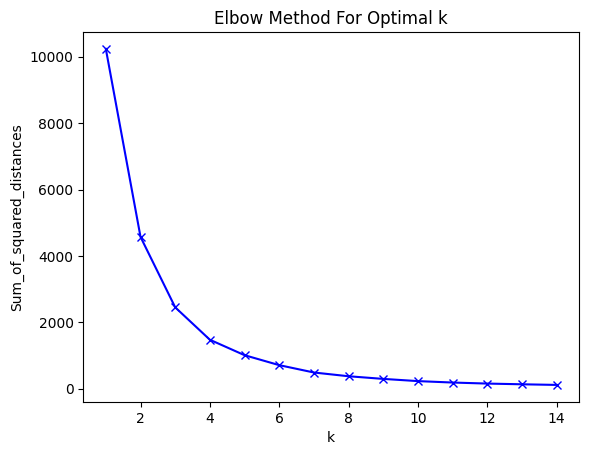

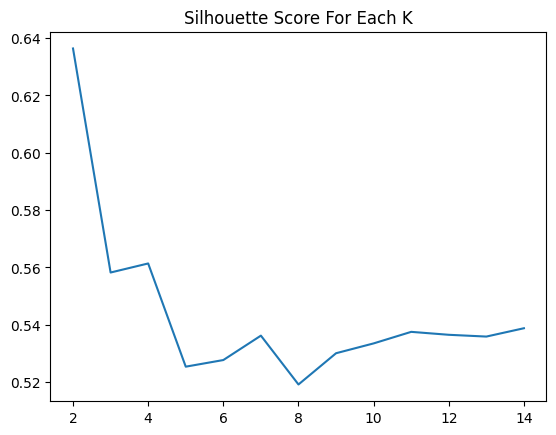

In [31]:
num_topics_silhouette_score(model1)

#### Cluster Visualisation

In [33]:
num_clusters = 6 ### CHANGE ACCORDINGLY
kmeans = KMeans(n_clusters=num_clusters, init='k-means++', max_iter=100) 
X = kmeans.fit(model1.dv.vectors) ### CHANGE MODEL NUMBER
labels = kmeans.labels_.tolist()

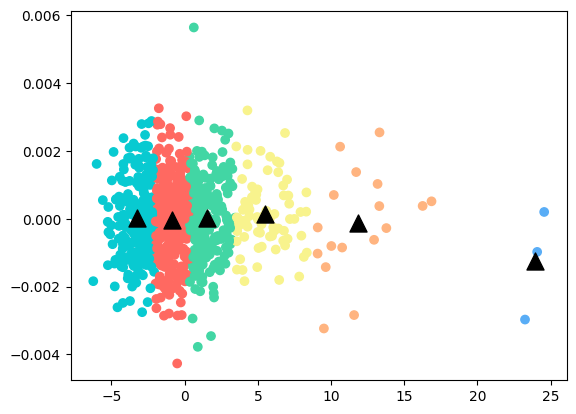

In [34]:
pca_plot(model1)

#### Cluster Interpretation

In [36]:
interpret_df = nearest_restaurants_to_centroid(model1)

0    300
4    232
3    217
2     76
1     17
5      3
Name: topics, dtype: int64


In [38]:
interpret_df[interpret_df['topics'] == 0]

,topics,url,cleaned_text
136,0,https://www.burpple.com/chalk-farm?bp_ref=%2Ff...,huge slice share easily basically ondeh ondeh ...
231,0,https://www.burpple.com/fat-po?bp_ref=%2Ff%2FJ...,im finally love fusion menu dish overkill lol ...
666,0,https://www.burpple.com/starter-lab-singapore?...,look soooo decadent cheese harden real quick h...
155,0,https://www.burpple.com/chix-hot-chicken?bp_re...,essentially fry chicken southern dry rub herb ...
760,0,https://www.burpple.com/tiong-bahru-bakery-5?b...,cny special tbb signature crisp buttery pastry...
741,0,https://www.burpple.com/the-neptune?bp_ref=%2F...,custard rich strong lime taste towards sour lo...
654,0,https://www.burpple.com/smile-dessert-grid?bp_...,refresh goodness brew green tea simple thirstq...
513,0,https://www.burpple.com/nipong-naepong-313-som...,beef chappong nipongnaepongsg comfort especial...
673,0,https://www.burpple.com/super-loco-customs-hou...,mild taste cocktail combination citrusy note l...
587,0,https://www.burpple.com/ps-cafe-raffles-city?b...,generous portion pasta bacon like smoke bacon ...


## Model 2
Appended additional adjective words

In [43]:
adj_tokenized_reviews = []
for review in tokenized_reviews:
    adj_tokenized = []
    for token in review:
        adj_tokenized.append(token)
        word, pos = nltk.pos_tag([token])[0]
        if pos == 'JJ' or pos == 'JJR' or pos == 'JJS' or pos == 'RB' or pos == 'RBR' or pos == 'RBS':
            adj_tokenized.append(token)
    adj_tokenized_reviews.append(adj_tokenized)

In [46]:
len(adj_tokenized_reviews[0])

1667

In [47]:
len(tokenized_reviews[0])

1390

In [48]:
it, model2 = doc2vec(adj_tokenized_reviews)

845
845


### Similarity Matrix

In [49]:
cosine_similarity_matrix(model2)

,https://www.burpple.com/108-matcha-saro?bp_ref=%2Ff%2F-9cTfRes,https://www.burpple.com/136-hong-kong-street-fish-head-steamboat-upper-aljunied-road?bp_ref=%2Ff%2FxPFOM3O2,https://www.burpple.com/15-stamford?bp_ref=%2Ff%2FV3JbHfZv,https://www.burpple.com/25-degrees-singapore?bp_ref=%2Ff%2F4bu64FGI,https://www.burpple.com/46-mittsu?bp_ref=%2Ff%2FYd46SA5p,https://www.burpple.com/49-seats-4?bp_ref=%2Ff%2FgMe8caYX,https://www.burpple.com/603-tau-sar-piah?bp_ref=%2Ff%2Foa6NzXzY,https://www.burpple.com/665-degrees-fahrenheit?bp_ref=%2Ff%2FK6qIZ3dx,https://www.burpple.com/726-west-coast-market?bp_ref=%2Ff%2Fw-wo2n5s,https://www.burpple.com/75-ah-balling-peanut-soup?bp_ref=%2Ff%2FJf2IPypA,...,https://www.burpple.com/yogostsg?bp_ref=%2Ff%2FnD1nZVe7,https://www.burpple.com/yong-huat?bp_ref=%2Ff%2Fzr6cmGkf,https://www.burpple.com/yum-cha-2?bp_ref=%2Ff%2Fq-H1rhKl,https://www.burpple.com/yun-nans-2?bp_ref=%2Ff%2Fy14zR297,https://www.burpple.com/yun-nans-nex?bp_ref=%2Ff%2F0dOBBrrw,https://www.burpple.com/yun-nans?bp_ref=%2Ff%2FYmjqWFA7,https://www.burpple.com/zafferano?bp_ref=%2Ff%2Fa86WC8Gr,https://www.burpple.com/zai-shun-curry-fish-head-seafood?bp_ref=%2Ff%2FguifIwH4,https://www.burpple.com/zazz-pizza?bp_ref=%2Ff%2FUx3U197Q,https://www.burpple.com/zoeys-diner?bp_ref=%2Ff%2FAuQ4WK7W
https://www.burpple.com/108-matcha-saro?bp_ref=%2Ff%2F-9cTfRes,1.000000,0.999985,0.999996,0.999994,0.999995,0.999992,0.999992,0.999990,0.999986,0.999991,...,0.999996,0.999996,0.999991,0.999991,0.999995,0.999995,0.999995,0.999988,0.999992,0.999993
https://www.burpple.com/136-hong-kong-street-fish-head-steamboat-upper-aljunied-road?bp_ref=%2Ff%2FxPFOM3O2,0.999985,1.000000,0.999988,0.999986,0.999987,0.999985,0.999983,0.999983,0.999977,0.999984,...,0.999988,0.999988,0.999983,0.999984,0.999987,0.999987,0.999987,0.999980,0.999984,0.999986
https://www.burpple.com/15-stamford?bp_ref=%2Ff%2FV3JbHfZv,0.999996,0.999988,1.000000,0.999997,0.999998,0.999995,0.999994,0.999994,0.999988,0.999995,...,0.999999,0.999999,0.999994,0.999995,0.999998,0.999998,0.999998,0.999991,0.999995,0.999996
https://www.burpple.com/25-degrees-singapore?bp_ref=%2Ff%2F4bu64FGI,0.999994,0.999986,0.999997,1.000000,0.999995,0.999993,0.999992,0.999992,0.999987,0.999992,...,0.999996,0.999997,0.999992,0.999992,0.999995,0.999996,0.999995,0.999989,0.999993,0.999994
https://www.burpple.com/46-mittsu?bp_ref=%2Ff%2FYd46SA5p,0.999995,0.999987,0.999998,0.999995,1.000000,0.999994,0.999992,0.999992,0.999987,0.999993,...,0.999997,0.999997,0.999993,0.999993,0.999996,0.999996,0.999996,0.999990,0.999994,0.999995
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
https://www.burpple.com/yun-nans?bp_ref=%2Ff%2FYmjqWFA7,0.999995,0.999987,0.999998,0.999996,0.999996,0.999994,0.999992,0.999992,0.999987,0.999993,...,0.999997,0.999998,0.999993,0.999994,0.999996,1.000000,0.999997,0.999990,0.999994,0.999994
https://www.burpple.com/zafferano?bp_ref=%2Ff%2Fa86WC8Gr,0.999995,0.999987,0.999998,0.999995,0.999996,0.999994,0.999993,0.999992,0.999987,0.999993,...,0.999997,0.999998,0.999993,0.999993,0.999996,0.999997,1.000000,0.999990,0.999994,0.999995
https://www.burpple.com/zai-shun-curry-fish-head-seafood?bp_ref=%2Ff%2FguifIwH4,0.999988,0.999980,0.999991,0.999989,0.999990,0.999987,0.999986,0.999985,0.999981,0.999987,...,0.999991,0.999991,0.999986,0.999986,0.999990,0.999990,0.999990,1.000000,0.999988,0.999988
https://www.burpple.com/zazz-pizza?bp_ref=%2Ff%2FUx3U197Q,0.999992,0.999984,0.999995,0.999993,0.999994,0.999991,0.999991,0.999990,0.999985,0.999990,...,0.999995,0.999995,0.999991,0.999991,0.999994,0.999994,0.999994,0.999988,1.000000,0.999992


### Text Clustering Using K-Means

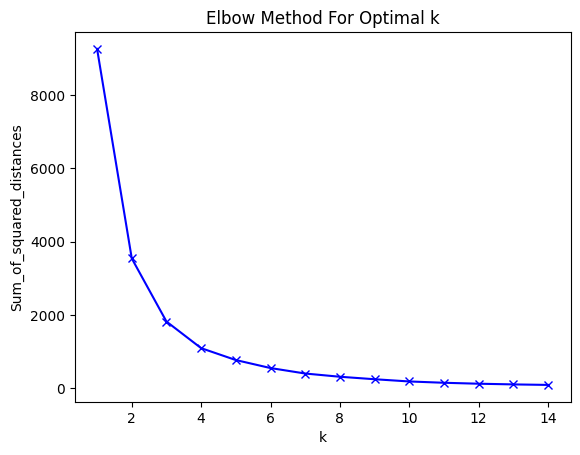

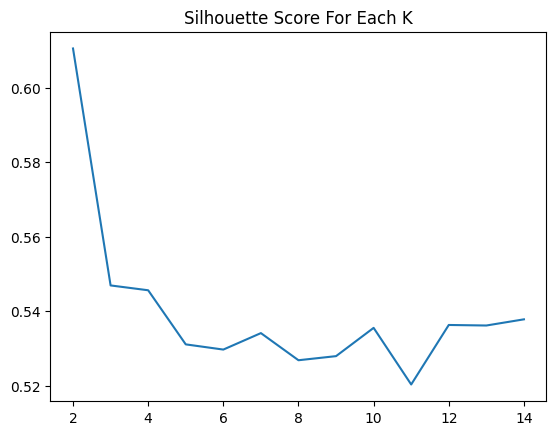

In [50]:
num_topics_silhouette_score(model2)

#### Cluster Visualisation

In [51]:
num_clusters = 6 ### CHANGE ACCORDINGLY
kmeans = KMeans(n_clusters=num_clusters, init='k-means++', max_iter=100) 
X = kmeans.fit(model1.dv.vectors) ### CHANGE MODEL NUMBER
labels = kmeans.labels_.tolist()

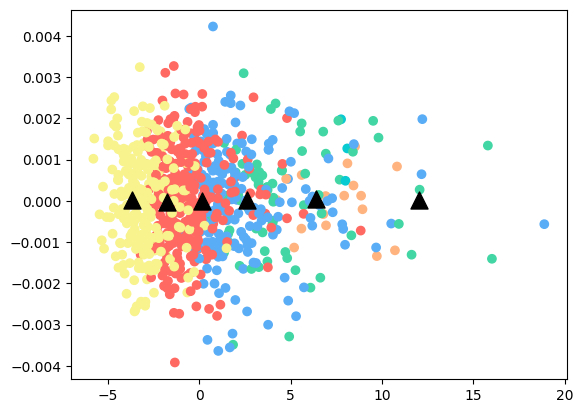

In [52]:
pca_plot(model2)

#### Cluster Interpretation

In [53]:
interpret_df = nearest_restaurants_to_centroid(model1)

0    309
2    237
5    209
3     70
1     17
4      3
Name: topics, dtype: int64


In [54]:
interpret_df[interpret_df['topics'] == 0]

,topics,url,cleaned_text
483,0,https://www.burpple.com/momolato?bp_ref=%2Ff%2...,knn literally wait 50 minute waffle order staf...
239,0,https://www.burpple.com/fluff-stack-northpoint...,mango pancake pancake long time pancake pancak...
499,0,https://www.burpple.com/munchi-delights?bp_ref...,flavour guarantee result enjoy like lor enjoy ...
458,0,https://www.burpple.com/maxwell-food-centre?bp...,basic decent 𝗛𝗮𝗶 𝗟𝗮𝗻 𝗕𝗮𝗻 𝗠𝗶𝗮𝗻 海兰板面鱼汤s tom yam ...
362,0,https://www.burpple.com/kelerollcake?bp_ref=%2...,certainly different cake roll hv ever eat flav...
817,0,https://www.burpple.com/xi-yan-shaw?bp_ref=%2F...,taste size true mark excellence simple cooking...
470,0,https://www.burpple.com/meta?bp_ref=%2Ff%2FFka...,try 𝑲𝒐𝒓𝒆𝒂𝒏 𝑯𝒆𝒓𝒊𝒕𝒂𝒈𝒆 𝑴𝒆𝒏𝒖 58 come bibimbap samg...
469,0,https://www.burpple.com/meta-restaurant?bp_ref...,try 𝑲𝒐𝒓𝒆𝒂𝒏 𝑯𝒆𝒓𝒊𝒕𝒂𝒈𝒆 𝑴𝒆𝒏𝒖 58 come bibimbap samg...
334,0,https://www.burpple.com/jade-restaurant-the-fu...,thumbs_upthumbs_up luxurious log cake decadent...
413,0,https://www.burpple.com/lefusionsg?bp_ref=%2Ff...,freshly prepared staff attentive cool decor in...


# OLD

#### bigram

In [ ]:
from gensim.models.phrases import Phrases, Phraser
# Build the bigram and trigram models
bigram = gensim.models.Phrases(tokenized_reviews) # higher threshold fewer phrases.

# Faster way to get a sentence clubbed as a trigram/bigram
bigram_mod = gensim.models.phrases.Phraser(bigram)

def make_bigrams(texts):
    return [bigram_mod[doc] for doc in texts]

bigram_reviews = make_bigrams(tokenized_reviews)

In [ ]:
it, model = doc2vec(bigram_reviews)

#### Trigram

In [ ]:
from gensim.models.phrases import Phrases, Phraser
# Build the bigram and trigram models
bigram = gensim.models.Phrases(tokenized_reviews) # higher threshold fewer phrases.

# Faster way to get a sentence clubbed as a trigram/bigram
bigram_mod = gensim.models.phrases.Phraser(bigram)

trigram = gensim.models.Phrases(bigram_mod['tokenized_reviews'])
trigram_mod = gensim.models.phrases.Phraser(trigram)


def make_trigrams(texts):
    return [trigram_mod[doc] for doc in texts]

trigram_reviews = make_trigrams(tokenized_reviews)

In [ ]:
it, model = doc2vec(trigram_reviews)

## Similarity

In [ ]:
it.labels_list[800]

In [ ]:
# get most similar restaurant to the first restaurant
# 'https://www.burpple.com/108-matcha-saro?bp_ref=%2Ff%2F-9cTfRes'
model.docvecs.most_similar(800)

In [ ]:
# similarity between 2 documents
model.docvecs.similarity(it.labels_list[0], it.labels_list[1])

In [ ]:
similarity_df = pd.DataFrame()

for restaurant in it.labels_list:
    similarity_list = []
    for restaurant2 in it.labels_list:
        similarity_list.append(model.docvecs.similarity(restaurant, restaurant2))
    
    similarity_df[restaurant] = similarity_list

In [ ]:
similarity_df.index = list(it.labels_list)

In [ ]:
similarity_df

# cosine similarity, jacquard smilarity, euclidean distance, manhatten distance

# similarity scores high coz vectors are similar
# currently, the vectors are too random. embedding method is not capturing the important data regarding the food items. pre-process dataset to remove words / give more importance to some words

In [ ]:
similarity_df.to_csv('doc2vec_restaurant_similarity_append_double.csv')

## Text Clustering using K-Means
by default kmeans uses euclidean distance

In [ ]:
# get optimal number of topics
Sum_of_squared_distances = []
K = range(1,15)
for k in K:
    kmeans = KMeans(n_clusters=k, init='k-means++', max_iter=100)
    X = kmeans.fit(model.dv.vectors) ###using documnet vecter numbers. doctag_syn0 calls doc2vec that is trained earlier.
    Sum_of_squared_distances.append(kmeans.inertia_)

plt.plot(K, Sum_of_squared_distances, 'bx-')
plt.xlabel('k')
plt.ylabel('Sum_of_squared_distances')
plt.title('Elbow Method For Optimal k')
plt.show()

In [ ]:
### K-means Accuracy (Silhouette Score)
from sklearn.metrics import silhouette_samples, silhouette_score
accuracy = []
for k in K:
    if k == 1:
        pass
    else: 
        kmeans = KMeans(n_clusters=k, init='k-means++', max_iter=100)
        X = kmeans.fit(model.dv.vectors) ###using documnet vecter numbers. doctag_syn0 calls doc2vec that is trained earlier.
        Sum_of_squared_distances.append(kmeans.inertia_)
        silhouette_score_average = silhouette_score(model.dv.vectors, kmeans.predict(model.dv.vectors))
        accuracy.append(silhouette_score_average)
x = list(range(2,len(K)+1))
plt.plot(x,accuracy)
plt.show()

In [ ]:
# elbow result shows 8 is the best
num_clusters = 6 ## or change to 6?
kmeans = KMeans(n_clusters=num_clusters, init='k-means++', max_iter=100) 
X = kmeans.fit(model.dv.vectors)
labels = kmeans.labels_.tolist()

# can get the representative words of each category 
# cosine similarity measure of the words
# LDA uses number of words in each review (prob of word uses)

In [ ]:
l = kmeans.fit_predict(model.dv.vectors)
pca = PCA(n_components=2).fit(model.dv.vectors)
datapoint = pca.transform(model.dv.vectors)

In [ ]:
plt.figure
label1 = ["#FF6961", "#FFB480", "#F8F38D", "#42D6A4", "#08CAD1", "#59ADF6", "#9D94FF", "#C780E8"]
color = [label1[i] for i in labels]
plt.scatter(datapoint[:, 0], datapoint[:, 1], c=color)

centroids = kmeans.cluster_centers_
centroidpoint = pca.transform(centroids)
plt.scatter(centroidpoint[:, 0], centroidpoint[:, 1], marker='^', s=150, c='#000000')
plt.show()

# if clustering not well, means word embedding is not clearly representing the topic
# get a set of food items from wikipedia & set of sentiment words (e.g. good, nice, awful, costly) words that are freuently in reviews
# find the frequency of these words in the dataset??
# use n-grams?

## Interpret Clusters
identify restaurants that are closest to the centroid

In [ ]:
# label each restaurant under 1 of the topics
restaurant_review_df['topics'] = labels
restaurant_review_df.head(5)

In [ ]:
# count of restaurants under each topic
restaurant_review_df['topics'].value_counts()

In [ ]:
from sklearn.metrics import pairwise_distances
distances = pairwise_distances(kmeans.cluster_centers_, model.dv.vectors, metric='euclidean')
closest_indexes = [np.argpartition(i, 10)[:10] for i in distances] # for each centroid, get the 10 nearest restaurants

In [ ]:
interpret_df = pd.DataFrame(columns=['topics', 'url', 'cleaned_text'])
for idx in closest_indexes:
    interpret_df = interpret_df.append(restaurant_review_df[['url', 'cleaned_text', 'topics']].iloc[idx])

interpret_df = interpret_df.sort_values(['topics'])

In [ ]:
interpret_df.to_csv('doc2vec_centroid_restaurants_' + str(num_clusters) + '_clusters_append_double.csv')

In [ ]:
interpret_df[interpret_df['topics'] == 0]

## One Hot Encode

In [ ]:
restaurant_review_df_encoded = restaurant_review_df.drop(['name', 'cleaned_text', 'price', 'categories', 'review', 'user', 'date', 'cleaned_categories'], axis=1)

In [ ]:
# one hot encode region & topics
region_dummies = pd.get_dummies(restaurant_review_df_encoded['region'])
neighbourhood_dummies = pd.get_dummies(restaurant_review_df_encoded['neighbourhood'])
topic_dummies = pd.get_dummies(restaurant_review_df_encoded['topics'])

restaurant_review_df_encoded = restaurant_review_df_encoded.drop(['region', 'neighbourhood', 'topics'], axis=1)
restaurant_review_df_encoded = restaurant_review_df_encoded.join(region_dummies)
restaurant_review_df_encoded = restaurant_review_df_encoded.join(neighbourhood_dummies)
restaurant_review_df_encoded = restaurant_review_df_encoded.join(topic_dummies)

In [ ]:
restaurant_review_df_encoded.head(5)

In [ ]:
restaurant_review_df_encoded.to_csv('doc2vec_labelled_restaurants_bigram.csv')

## WordCloud

In [ ]:
from wordcloud import WordCloud
from sklearn.feature_extraction.text import TfidfVectorizer

In [ ]:
# concatenate all the reviews for each topic
topic_df = interpret_df[['topics', 'cleaned_text']]
topic_df = topic_df.groupby(['topics'], as_index = False).agg({'cleaned_text': ' '.join})
topic_df

In [ ]:
# TF-IDF
text = topic_df['cleaned_text']
vectorizer = TfidfVectorizer(stop_words='english')
X = vectorizer.fit_transform(text)
feature_names = vectorizer.get_feature_names_out()
dense = X.todense()
denselist = dense.tolist()
df = pd.DataFrame(denselist, columns=feature_names).transpose()
df.columns = topic_df['topics']

In [ ]:
wordcloud = WordCloud(background_color = 'white', collocations = False).generate_from_text(text[0])
# Display the generated Word Cloud
plt.imshow(wordcloud)
plt.axis("off")
plt.show()

In [ ]:
wordcloud = WordCloud(background_color = 'white', collocations = False).generate_from_frequencies(df[0])
# Display the generated Word Cloud
plt.imshow(wordcloud)
plt.axis("off")
plt.show()

In [ ]:
wordcloud = WordCloud(background_color = 'white', collocations = False).generate_from_text(text[1])
# Display the generated Word Cloud
plt.imshow(wordcloud)
plt.axis("off")
plt.show()

In [ ]:
wordcloud = WordCloud(background_color = 'white', collocations = False).generate_from_frequencies(df[1])
# Display the generated Word Cloud
plt.imshow(wordcloud)
plt.axis("off")
plt.show()

In [ ]:
wordcloud = WordCloud(background_color = 'white', collocations = False).generate_from_frequencies(df[2])
# Display the generated Word Cloud
plt.imshow(wordcloud)
plt.axis("off")
plt.show()

In [ ]:
wordcloud = WordCloud(background_color = 'white', collocations = False).generate_from_frequencies(df[3])
# Display the generated Word Cloud
plt.imshow(wordcloud)
plt.axis("off")
plt.show()

In [ ]:
wordcloud = WordCloud(background_color = 'white', collocations = False).generate_from_frequencies(df[4])
# Display the generated Word Cloud
plt.imshow(wordcloud)
plt.axis("off")
plt.show()

In [ ]:
wordcloud = WordCloud(background_color = 'white', collocations = False).generate_from_frequencies(df[5])
# Display the generated Word Cloud
plt.imshow(wordcloud)
plt.axis("off")
plt.show()